In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import  optim
from torch import nn
from sklearn import datasets, manifold
import os
import copy
import sys
import torch
from pytorch3d.loss import chamfer_distance
from torch.utils.data import DataLoader
from itertools import combinations
from torch.autograd import Variable
import torch.nn.functional as F
import time, datetime
from losses import max_cos_disimilarity_wassersten_distance
from losses import Norm_Flow_structure
from losses import Geodesic_distance_W
from losses import Cos_disimilarity_W
from losses import sliced_wasserstein_sphere
import pandas as pd
import ot
from pylab import rcParams
from datas import *
BASE_DIR = os.getcwd()
device = torch.device("cuda:3") if torch.cuda.is_available() else torch.device("cpu")
seed = 0

In [2]:
"""
シード固定
"""
def fix_seed(seed):
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed+ 1)
    torch.cuda.manual_seed_all(seed + 2)
    torch.backends.cudnn.deterministic = True

fix_seed(seed)

In [3]:
# plt.rcParams['font.family'] ='Arial' #使用するフォント
plt.rcParams['font.family'] = 'DejaVu Serif' #_ 日本語入力の際はIPAexGothicを用いる
fontsize = 20
plt.rcParams['font.size'] = fontsize #フォントの大きさ
plt.rcParams['xtick.labelsize'] = fontsize #x軸の目盛りのフォントの大きさ
plt.rcParams['ytick.labelsize'] = fontsize #y軸の目盛りのフォントの大きさ
plt.rcParams['axes.labelsize'] = fontsize #軸の名前のフォントの大きさ

plt.rcParams['xtick.major.size'] = 6.0 #x軸主目盛り線の線の長さ
plt.rcParams['ytick.major.size'] = 6.0 #y軸主目盛り線の長さ
plt.rcParams['ytick.minor.size'] = 5.0 #y軸補助目盛り線の長さ
plt.rcParams['xtick.major.width'] = 1.5 #x軸主目盛り線の線幅
plt.rcParams['ytick.major.width'] = 1.5 #y軸主目盛り線の線幅
plt.rcParams['ytick.minor.width'] = 1.2 #y軸補助目盛り線の線幅

plt.rcParams['axes.linewidth'] = 1.5 # 軸の線幅edge linewidth。囲みの太さ
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

rcParams['figure.figsize'] = 10, 5#画像の大きさ

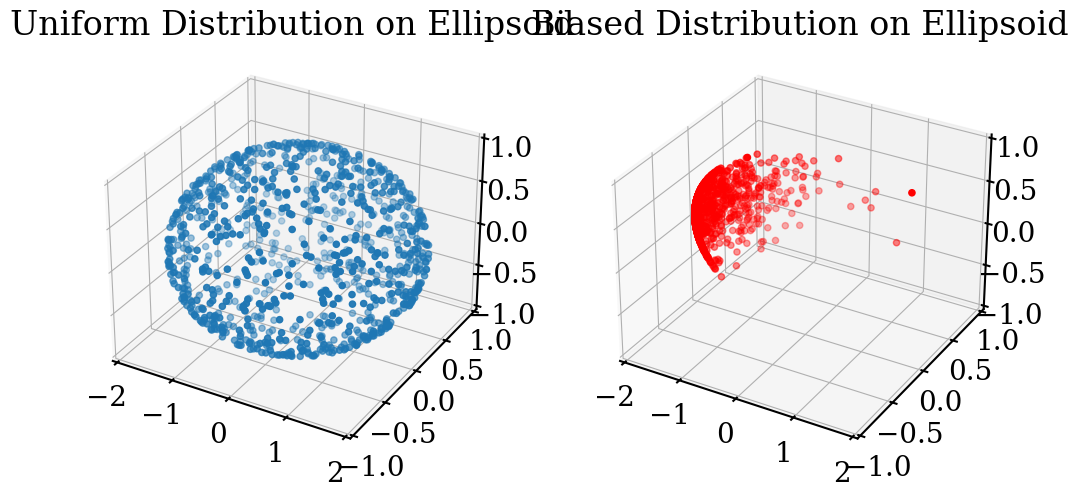

In [4]:
def generate_uniform_points_on_ellipsoid(num_points, a, b, c):
    """
    Generate uniformly distributed points on the surface of an ellipsoid.

    :param num_points: Number of points to generate
    :param a, b, c: Semi-axes of the ellipsoid
    :return: Numpy array of shape (num_points, 3)
    """
    points = []

    for _ in range(num_points):
        phi = np.random.uniform(0, 2 * np.pi)
        theta = np.arccos(np.random.uniform(-1, 1))

        x = a * np.sin(theta) * np.cos(phi)
        y = b * np.sin(theta) * np.sin(phi)
        z = c * np.cos(theta)

        points.append([x, y, z])

    return np.array(points)

def generate_biased_points_on_ellipsoid(num_points, a, b, c, scale):
    """
    Generate biased distributed points on the surface of an ellipsoid.

    :param num_points: Number of points to generate
    :param a, b, c: Semi-axes of the ellipsoid
    :param scale: Standard deviation for the biased distribution
    :return: Numpy array of shape (num_points, 3)
    """
    points = []

    for _ in range(num_points):
        # phi = np.random.uniform(0, 2 * np.pi)
        phi = 2* np.arccos(np.random.normal(0, scale))
        theta = np.arccos(np.random.normal(0, scale))

        # Adjust theta to be within valid range
        phi = np.clip(phi, 0, np.pi)
        theta = np.clip(theta, 0, np.pi)

        x = a * np.sin(theta) * np.cos(phi)
        y = b * np.sin(theta) * np.sin(phi)
        z = c * np.cos(theta)

        points.append([x, y, z])

    return np.array(points)

# Parameters
num_points = 1000
a, b, c = 2, 1, 1  # Semi-axes of the ellipsoid
scale = 0.25  # Standard deviation for the biased distribution

# Generate points
uniform_points = generate_uniform_points_on_ellipsoid(num_points, a, b, c)
biased_points = generate_biased_points_on_ellipsoid(num_points, a, b, c, scale)

# Plotting
fig = plt.figure(figsize=(12, 6))

# Uniform distribution
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(uniform_points[:, 0], uniform_points[:, 1], uniform_points[:, 2])
ax1.set_title("Uniform Distribution on Ellipsoid")
ax1.set_xlim([-a, a])
ax1.set_ylim([-b, b])
ax1.set_zlim([-c, c])

# Biased distribution
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(biased_points[:, 0], biased_points[:, 1], biased_points[:, 2], color='red')
ax2.set_title("Biased Distribution on Ellipsoid")
ax2.set_xlim([-a, a])
ax2.set_ylim([-b, b])
ax2.set_zlim([-c, c])

plt.show()


In [5]:
biased_points_ellipsoid_torch =torch.from_numpy(biased_points).type(torch.FloatTensor)
uniform_points_ellipsoid_torch =torch.from_numpy(uniform_points).type(torch.FloatTensor)

In [6]:
def rand_projections(dim, num_projections=100):
    projections = torch.randn((num_projections, dim))
    projections = projections / torch.sqrt(torch.sum(projections ** 2, dim=1, keepdim=True))
    return projections

def sliced_wasserstein_distance(first_samples,
                                second_samples,
                                num_projection=100,
                                p=2,
                                device='cuda'):
    dim = second_samples.size(1)
    projections = rand_projections(dim, num_projections).to(device)
    first_projections = first_samples.matmul(projections.transpose(0, 1))
    second_projections = (second_samples.matmul(projections.transpose(0, 1)))
    wasserstein_distance = torch.abs((torch.sort(first_projections.transpose(0, 1), dim=1)[0] -
                            torch.sort(second_projections.transpose(0, 1), dim=1)[0]))
    wasserstein_distance = torch.pow(torch.sum(torch.pow(wasserstein_distance, p), dim=1),1./p)
    return torch.pow(torch.pow(wasserstein_distance, p).mean(),1./p)

def max_sliced_wasserstein_distance(first_samples,
                                second_samples,
                                num_projection=100,
                                p=2,max_iter=10,
                                device='cuda'):
    dim = second_samples.size(1)
    num_projection=1
    first_samples_detach = first_samples.detach()
    second_samples_detach = second_samples.detach()
    projections = rand_projections(dim, 1).to(device)
    projections.requires_grad_()
    optimizer=optim.Adam([projections], lr=0.005, betas=(0.999, 0.999))
    for i in range(max_iter):
      first_projections = first_samples_detach.matmul(projections.transpose(0, 1))
      second_projections = second_samples_detach.matmul(projections.transpose(0, 1))
      wasserstein_distance = torch.abs((torch.sort(first_projections.transpose(0, 1), dim=1)[0] -
                              torch.sort(second_projections.transpose(0, 1), dim=1)[0]))
      wasserstein_distance = torch.sum(torch.pow(wasserstein_distance, p), dim=1)
      wasserstein_distance = torch.pow(wasserstein_distance.mean(),1./p)
      optimizer.zero_grad()
      loss=-wasserstein_distance
      loss.backward(retain_graph=True)
      optimizer.step()
      projections.data = projections.data / torch.sqrt(torch.sum(projections.data ** 2, dim=1))
    first_projections = first_samples.matmul(projections.transpose(0, 1))
    second_projections = second_samples.matmul(projections.transpose(0, 1))
    wasserstein_distance = torch.abs((torch.sort(first_projections.transpose(0, 1), dim=1)[0] -
                                      torch.sort(second_projections.transpose(0, 1), dim=1)[0]))
    wasserstein_distance = torch.sum(torch.pow(wasserstein_distance, p), dim=1)
    wasserstein_distance = torch.pow(wasserstein_distance.mean(),1./p)
    return wasserstein_distance  
def poly_degree(degree,dim):
    comb=combinations(np.arange(1,degree+dim),dim-1)
    comb=list(comb)
    x_degree=np.zeros([len(comb),dim])
    for (i,c) in enumerate(comb):
        c=list(c)
        c.append(degree+dim)
        for (j,index) in enumerate(c):
            if j == 0:
                x_degree[i,j]=index-1
            else:
                x_degree[i,j]=index-c[j-1]-1
    return torch.from_numpy(x_degree).type(torch.FloatTensor)
def polynomial_function(samples, parameters, device='cuda'):
    theta, degree_matrix = parameters[0], parameters[1]
    prod_value_poly = torch.zeros(samples.shape[0], degree_matrix.shape[0]).to(device)
    degree_matrix = degree_matrix.unsqueeze(0).expand(samples.shape[0], degree_matrix.shape[0],
                                                      degree_matrix.shape[1])
    samples = samples.unsqueeze(1).expand(samples.shape[0], degree_matrix.shape[1], samples.shape[1])
    exp_matrix = samples ** degree_matrix
    polynomial_function_value = torch.matmul(torch.prod(exp_matrix, -1), theta)
    return polynomial_function_value

def max_GSWD_polynomial_3(encoded_samples,distribution_samples,p=2,num_projection=100,degree=3 ,device='cuda',max_iter=10):
    num_projection=1
    mat_1 = poly_degree(degree, encoded_samples.shape[-1]).to(device)
    coefficient_1 = torch.randn((mat_1.shape[0], num_projection), device=device)
    coefficient_1.data = coefficient_1.data / torch.sqrt(torch.sum(coefficient_1.data ** 2, dim=0))
    coefficient_1.requires_grad_()
    optimizer=optim.Adam([coefficient_1], lr=0.005, betas=(0.999, 0.999))
    for i in range(max_iter):
      encoded_projections=polynomial_function(encoded_samples.detach(),[coefficient_1,mat_1.detach()])
      distribution_projections=polynomial_function(distribution_samples.detach(),[coefficient_1,mat_1.detach()])
      wasserstein_distance=torch.abs(torch.sort(encoded_projections.transpose(0,1),dim=1)[0]-
                                    torch.sort(distribution_projections.transpose(0,1),dim=1)[0])
      wasserstein_distance=torch.sum(torch.pow(wasserstein_distance,p),dim=-1)
      wasserstein_distance=torch.pow(torch.mean(wasserstein_distance),1./p)
      optimizer.zero_grad()
      loss=-wasserstein_distance
      loss.backward(retain_graph=True)
      optimizer.step()
      coefficient_1.data = coefficient_1.data / torch.sqrt(torch.sum(coefficient_1.data ** 2, dim=0))
    encoded_projections=polynomial_function(encoded_samples,[coefficient_1.detach(),mat_1.detach()])
    distribution_projections=polynomial_function(distribution_samples,[coefficient_1.detach(),mat_1.detach()])
    wasserstein_distance=torch.abs(torch.sort(encoded_projections.transpose(0,1),dim=1)[0]-
                                   torch.sort(distribution_projections.transpose(0,1),dim=1)[0])
    wasserstein_distance=torch.sum(torch.pow(wasserstein_distance,p),dim=-1)
    wasserstein_distance=torch.pow(torch.mean(wasserstein_distance),1./p)
    return wasserstein_distance

def max_GSWD_polynomial_5(encoded_samples,distribution_samples,p=2,num_projection=100,degree=5 ,device='cuda',max_iter=10):
    num_projection=1
    mat_1 = poly_degree(degree, encoded_samples.shape[-1]).to(device)
    coefficient_1 = torch.randn((mat_1.shape[0], num_projection), device=device, requires_grad=True)
    coefficient_1.data = coefficient_1.data / torch.sqrt(torch.sum(coefficient_1.data ** 2, dim=0))
    optimizer=optim.Adam([coefficient_1], lr=0.005, betas=(0.999, 0.999))
    for i in range(max_iter):
      encoded_projections=polynomial_function(encoded_samples.detach(),[coefficient_1,mat_1.detach()])
      distribution_projections=polynomial_function(distribution_samples.detach(),[coefficient_1,mat_1.detach()])
      wasserstein_distance=torch.abs(torch.sort(encoded_projections.transpose(0,1),dim=1)[0]-
                                    torch.sort(distribution_projections.transpose(0,1),dim=1)[0])
      wasserstein_distance=torch.sum(torch.pow(wasserstein_distance,p),dim=-1)
      wasserstein_distance=torch.pow(torch.mean(wasserstein_distance),1./p)
      optimizer.zero_grad()
      loss=-wasserstein_distance
      loss.backward(retain_graph=True)
      optimizer.step()
      coefficient_1.data = coefficient_1.data / torch.sqrt(torch.sum(coefficient_1.data ** 2, dim=0))
    encoded_projections=polynomial_function(encoded_samples,[coefficient_1.detach(),mat_1.detach()])
    distribution_projections=polynomial_function(distribution_samples,[coefficient_1.detach(),mat_1.detach()])
    wasserstein_distance=torch.abs(torch.sort(encoded_projections.transpose(0,1),dim=1)[0]-
                                   torch.sort(distribution_projections.transpose(0,1),dim=1)[0])
    wasserstein_distance=torch.sum(torch.pow(wasserstein_distance,p),dim=-1)
    wasserstein_distance=torch.pow(torch.mean(wasserstein_distance),1./p)
    return wasserstein_distance

def GSWD_polynomial(encoded_samples,distribution_samples,p=2,num_projection=100,degree=5 ,device='cuda'):
    mat_1 = poly_degree(degree, encoded_samples.shape[-1]).to(device)
    coefficient_1 = torch.randn((mat_1.shape[0], num_projection), device=device, requires_grad=True)
    coefficient_1.data = coefficient_1.data / torch.sqrt(torch.sum(coefficient_1.data ** 2, dim=0))
    encoded_projections=polynomial_function(encoded_samples,[coefficient_1.detach(),mat_1.detach()])
    distribution_projections=polynomial_function(distribution_samples,[coefficient_1.detach(),mat_1.detach()])
    wasserstein_distance=torch.abs(torch.sort(encoded_projections.transpose(0,1),dim=1)[0]-
                                   torch.sort(distribution_projections.transpose(0,1),dim=1)[0])
    wasserstein_distance=torch.sum(torch.pow(wasserstein_distance,p),dim=-1)
    wasserstein_distance=torch.pow(torch.mean(wasserstein_distance),1./p)
    return wasserstein_distance

def GSWD_circular(encoded_samples,distribution_samples,p=2,num_projection=100,r=1,device='cuda'):
    theta = torch.randn((num_projection, encoded_samples.shape[1])).to(device)
    theta = theta / torch.sqrt(torch.sum(theta ** 2, dim=1, keepdim=True))
    cost_matrix_1 = torch.sqrt(cost_matrix(encoded_samples, theta * r))
    cost_matrix_2 = torch.sqrt(cost_matrix(distribution_samples, theta * r))
    wasserstein_distance = torch.abs(torch.sort(cost_matrix_1.transpose(0, 1), dim=1)[0] -
                                      torch.sort(cost_matrix_2.transpose(0, 1), dim=1)[0])
    wasserstein_distance =torch.sum(torch.pow(wasserstein_distance, p), dim=1)
    return torch.pow(wasserstein_distance.mean(), 1. / p)

def max_GSWD_circular(encoded_samples,distribution_samples,p=2,num_projection=1,r=1,device='cuda',max_iter=10):
    num_projection=1
    theta = torch.randn((num_projection, encoded_samples.shape[1])).to(device)
    theta.data = theta.data / torch.sqrt(torch.sum(theta.data ** 2, dim=1, keepdim=True))
    theta.requires_grad_()
    optimizer=optim.Adam([theta], lr=0.005, betas=(0.999, 0.999))

    for i in range(max_iter):
      cost_matrix_1 = torch.sqrt(cost_matrix(encoded_samples.detach(), theta * r))
      cost_matrix_2 = torch.sqrt(cost_matrix(distribution_samples.detach(), theta * r))
      wasserstein_distance = torch.abs(torch.sort(cost_matrix_1.transpose(0, 1), dim=1)[0] -
                                        torch.sort(cost_matrix_2.transpose(0, 1), dim=1)[0])
      wasserstein_distance =torch.sum(torch.pow(wasserstein_distance, p), dim=1)
      wasserstein_distance=torch.pow(wasserstein_distance.mean(), 1. / p)
      optimizer.zero_grad()
      loss=-wasserstein_distance
      loss.backward(retain_graph=True)
      optimizer.step()
      theta.data = theta.data / torch.sqrt(torch.sum(theta.data ** 2, dim=1))
    cost_matrix_1 = torch.sqrt(cost_matrix(encoded_samples, theta * r))
    cost_matrix_2 = torch.sqrt(cost_matrix(distribution_samples, theta * r))
    wasserstein_distance = torch.abs(torch.sort(cost_matrix_1.transpose(0, 1), dim=1)[0] -
                                      torch.sort(cost_matrix_2.transpose(0, 1), dim=1)[0])
    wasserstein_distance =torch.sum(torch.pow(wasserstein_distance, p), dim=1)
    return torch.pow(wasserstein_distance.mean(), 1. / p)

def circular_function(samples, parameters):
    radial, theta = parameters[0], parameters[1]
    cost_matrix_1 = torch.sqrt(cost_matrix(samples, theta * radial))
    return cost_matrix_1

def cost_matrix(encoded_samples, distribution_samples, p=2):
    n = encoded_samples.size(0)
    m = distribution_samples.size(0)
    d = encoded_samples.size(1)
    return ((encoded_samples.reshape(n,d,1)-distribution_samples.transpose(1,0).unsqueeze(0))**2).sum(1)

def GSWD_polynomial3(encoded_samples,distribution_samples,p=2,num_projection=100,device='cuda'):
    theta = torch.randn((num_projection, 4)).to(device)
    theta = theta / torch.sqrt(torch.sum(theta ** 2, dim=1, keepdim=True))
    encoded_samples_=torch.ones(encoded_samples.shape[0],4).to(device)
    distribution_samples_=torch.ones(distribution_samples.shape[0],4).to(device)
    encoded_samples_[:,0],encoded_samples_[:,1],encoded_samples_[:,2],encoded_samples_[:,3]=encoded_samples[:,1]**3,encoded_samples[:,0]*encoded_samples[:,1]**2,encoded_samples[:,0]**2*encoded_samples[:,1],encoded_samples[:,0]**3
    distribution_samples_[:,0],distribution_samples_[:,1],distribution_samples_[:,2],distribution_samples_[:,3]=distribution_samples[:,1]**3,distribution_samples[:,0]*distribution_samples[:,1]**2,distribution_samples[:,0]**2*distribution_samples[:,1]**1,distribution_samples[:,0]**3
    encoded_projections=encoded_samples_.matmul(theta.transpose(0,1))
    distribution_projections=distribution_samples_.matmul(theta.transpose(0,1))
    wasserstein_distance=torch.abs(torch.sort(encoded_projections.transpose(0,1),dim=1)[0]-
                                   torch.sort(distribution_projections.transpose(0,1),dim=1)[0])
    wasserstein_distance=torch.sum(torch.pow(wasserstein_distance,p),dim=-1)
    wasserstein_distance=torch.pow(torch.mean(wasserstein_distance),1./p)
    return wasserstein_distance

from torch import nn
class Mapping(nn.Module):
    def __init__(self, size):
        super(Mapping, self).__init__()
        self.size = size
        self.net = nn.Sequential(nn.Linear(self.size, self.size))
    def forward(self, inputs):
        outputs =self.net(inputs)
        return torch.cat((inputs,outputs),dim=-1)

def augmented_sliced_wassersten_distance(first_samples,second_samples,num_projections,phi,
                                                       phi_op,p=2,max_iter=10,lam=20,device='cuda',net_type='fc'):
    embedding_dim = first_samples.size(1)
    first_samples_detach = first_samples.detach()
    second_samples_detach = second_samples.detach()
    for _ in range(max_iter):
        first_samples_transform=phi(first_samples_detach)
        second_samples_transform = phi(second_samples_detach)
        reg=lam*(torch.norm(first_samples_transform,p=2,dim=1)+torch.norm(second_samples_transform,p=2,dim=1)).mean()
        projections = rand_projections(first_samples_transform.shape[-1], num_projections).to(device)
        encoded_projections = first_samples_transform.matmul(projections.transpose(0, 1))
        distribution_projections = (second_samples_transform.matmul(projections.transpose(0, 1)))
        wasserstein_distance = torch.abs((torch.sort(encoded_projections.transpose(0, 1), dim=1)[0] -
                                torch.sort(distribution_projections.transpose(0, 1), dim=1)[0]))
        wasserstein_distance = torch.sum(torch.pow(wasserstein_distance, p), dim=1)*512/first_samples_detach.shape[0]
        wasserstein_distance = torch.pow(wasserstein_distance.mean(), 1. / p)
        loss=reg-wasserstein_distance
        phi_op.zero_grad()
        loss.backward(retain_graph=True)
        phi_op.step()
    first_samples_transform = phi(first_samples)
    second_samples_transform = phi(second_samples)
    projections=rand_projections(first_samples_transform.shape[-1], num_projections).to(device)
    encoded_projections = first_samples_transform.matmul(projections.transpose(0, 1))
    distribution_projections = second_samples_transform.matmul(projections.transpose(0, 1))
    wasserstein_distance = torch.abs((torch.sort(encoded_projections.transpose(0, 1), dim=1)[0] -
                                      torch.sort(distribution_projections.transpose(0, 1), dim=1)[0]))
    wasserstein_distance = torch.sum(torch.pow(wasserstein_distance, p), dim=1)
    wasserstein_distance = torch.pow(wasserstein_distance.mean(), 1. / p)
    return  wasserstein_distance

class TransformNet(nn.Module):
    def __init__(self, size):
        super(TransformNet, self).__init__()
        self.size = size
        self.net = nn.Sequential(nn.Linear(self.size,self.size))
    def forward(self, input):
        out =self.net(input)
        return out/torch.sqrt(torch.sum(out**2,dim=1,keepdim=True))

def cosine_distance_torch(x1, x2=None, eps=1e-8):
    x2 = x1 if x2 is None else x2
    w1 = x1.norm(p=2, dim=1, keepdim=True)
    w2 = w1 if x2 is x1 else x2.norm(p=2, dim=1, keepdim=True)
    return torch.mean(torch.abs(torch.mm(x1, x2.t()) / (w1 * w2.t()).clamp(min=eps)))

def distributional_sliced_wasserstein_distance(first_samples, second_samples, num_projections, f, f_op,
                                               p=2, max_iter=10, lam=1, device='cuda'):
    embedding_dim = first_samples.size(1)
    pro = rand_projections(embedding_dim, num_projections).to(device)
    first_samples_detach = first_samples.detach()
    second_samples_detach = second_samples.detach()
    for _ in range(max_iter):
        
        pro = rand_projections(embedding_dim, num_projections).to(device)
        projections = f(pro)
        reg = lam * cosine_distance_torch(projections, projections)
        encoded_projections = first_samples_detach.matmul(projections.transpose(0, 1))
        distribution_projections = (second_samples_detach.matmul(projections.transpose(0, 1)))
        wasserstein_distance = torch.abs((torch.sort(encoded_projections.transpose(0, 1), dim=1)[0] -
                                torch.sort(distribution_projections.transpose(0, 1), dim=1)[0]))
        wasserstein_distance = torch.pow(torch.sum(torch.pow(wasserstein_distance, p), dim=1),1./p)
        wasserstein_distance = torch.pow(torch.pow(wasserstein_distance, p).mean(),1./p)
        loss = reg - wasserstein_distance
        f_op.zero_grad()
        loss.backward(retain_graph=True)
        f_op.step()
    pro = rand_projections(embedding_dim, num_projections).to(device)
    projections = f(pro)
    encoded_projections = first_samples.matmul(projections.transpose(0, 1))
    distribution_projections = (second_samples.matmul(projections.transpose(0, 1)))
    wasserstein_distance = torch.abs((torch.sort(encoded_projections.transpose(0, 1), dim=1)[0] -
                            torch.sort(distribution_projections.transpose(0, 1), dim=1)[0]))
    wasserstein_distance = torch.sum(torch.pow(wasserstein_distance, p), dim=1)
    wasserstein_distance = torch.pow(wasserstein_distance.mean(), 1. / p)
    return wasserstein_distance
class MLP(nn.Module):
    def __init__(self, din=2,dout=10, num_filters=32, depth=3):
        super(MLP, self).__init__()
        self.din=din
        self.dout=dout
        self.init_num_filters = num_filters
        self.depth=depth

        self.features = nn.Sequential()
        
        for i in range(self.depth):
            if i==0:
                self.features.add_module('linear%02d'%(i+1),nn.Linear(self.din,self.init_num_filters))        
            else:
                self.features.add_module('linear%02d'%(i+1),nn.Linear(self.init_num_filters,self.init_num_filters))
            self.features.add_module('activation%02d'%(i+1),nn.LeakyReLU(inplace=True))

        self.features.add_module('linear%02d'%(i+2),nn.Linear(self.init_num_filters,self.dout))
    
    def forward(self, x):        
        return self.features(x)
    
    def init_weights(self,m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def reset(self):
        self.features.apply(self.init_weights)

def gsw_nn_1(first_samples, second_samples, net,net_op,max_iter=10,p=2):
  encoded_projections=net(first_samples)
  distribution_projections=net(second_samples)
  wasserstein_distance = torch.abs((torch.sort(encoded_projections.transpose(0, 1), dim=1)[0] -
                          torch.sort(distribution_projections.transpose(0, 1), dim=1)[0]))
  wasserstein_distance = torch.sum(torch.pow(wasserstein_distance, p), dim=1)
  wasserstein_distance = torch.pow(wasserstein_distance.mean(), 1. / p)
  return wasserstein_distance

def gsw_nn_3(first_samples, second_samples, net,net_op,max_iter=10,p=2):
  encoded_projections=net(first_samples)
  distribution_projections=net(second_samples)
  wasserstein_distance = torch.abs((torch.sort(encoded_projections.transpose(0, 1), dim=1)[0] -
                          torch.sort(distribution_projections.transpose(0, 1), dim=1)[0]))
  wasserstein_distance = torch.sum(torch.pow(wasserstein_distance, p), dim=1)
  wasserstein_distance = torch.pow(wasserstein_distance.mean(), 1. / p)
  return wasserstein_distance

def max_gsw_nn_1(first_samples, second_samples, net, net_op, max_iter=10,p=2):

  for i in range(max_iter):
    encoded_projections=net(first_samples.detach())
    distribution_projections=net(second_samples.detach())
    wasserstein_distance = torch.abs((torch.sort(encoded_projections.transpose(0, 1), dim=1)[0] -
                            torch.sort(distribution_projections.transpose(0, 1), dim=1)[0]))
    wasserstein_distance = torch.sum(torch.pow(wasserstein_distance, p), dim=1)
    wasserstein_distance = torch.pow(wasserstein_distance.mean(), 1. / p)
    loss=-wasserstein_distance
    net_op.zero_grad()
    loss.backward(retain_graph=True)
    net_op.step()
  encoded_projections=net(first_samples)
  distribution_projections=net(second_samples)
  wasserstein_distance = torch.abs((torch.sort(encoded_projections.transpose(0, 1), dim=1)[0] -
                          torch.sort(distribution_projections.transpose(0, 1), dim=1)[0]))
  wasserstein_distance = torch.sum(torch.pow(wasserstein_distance, p), dim=1)
  wasserstein_distance = torch.pow(wasserstein_distance.mean(), 1. / p)
  return wasserstein_distance

def max_gsw_nn_3(first_samples, second_samples, net, net_op, max_iter=10,p=2):

  for i in range(max_iter):
    encoded_projections=net(first_samples.detach())
    distribution_projections=net(second_samples.detach())
    wasserstein_distance = torch.abs((torch.sort(encoded_projections.transpose(0, 1), dim=1)[0] -
                            torch.sort(distribution_projections.transpose(0, 1), dim=1)[0]))
    wasserstein_distance = torch.sum(torch.pow(wasserstein_distance, p), dim=1)
    wasserstein_distance = torch.pow(wasserstein_distance.mean(), 1. / p)
    loss=-wasserstein_distance
    net_op.zero_grad()
    loss.backward(retain_graph=True)
    net_op.step()
  encoded_projections=net(first_samples)
  distribution_projections=net(second_samples)
  wasserstein_distance = torch.abs((torch.sort(encoded_projections.transpose(0, 1), dim=1)[0] -
                          torch.sort(distribution_projections.transpose(0, 1), dim=1)[0]))
  wasserstein_distance = torch.sum(torch.pow(wasserstein_distance, p), dim=1)
  wasserstein_distance = torch.pow(wasserstein_distance.mean(), 1. / p)
  return wasserstein_distance


"""
W loss
"""
def wasserstein_distance(x, y , device, p = 2):
    C = cost_matrix(x, y, p).to(device)
    x_points = x.shape[-2]
    y_points = y.shape[-2]
    if x.dim() == 2:
        batch_size = 1
    else:
        batch_size = x.shape[0]
    # probability vectors (経験分布なら 1/ sample size)
    probability_vector_of_x = torch.empty(batch_size, x_points, dtype=torch.float, requires_grad=False).fill_(1.0 / x_points).squeeze().to(device)
    probability_vector_of_y = torch.empty(batch_size, y_points, dtype=torch.float, requires_grad=False).fill_(1.0 / y_points).squeeze().to(device)
    emd = torch.pow(ot.emd2(probability_vector_of_x, probability_vector_of_y, C), 1. / p)
    return emd


def wasserstein_distance_geo(x, y , device, p = 2):
    C = geodesic_cost_matrix(x, y, p).to(device)
    x_points = x.shape[-2]
    y_points = y.shape[-2]
    if x.dim() == 2:
        batch_size = 1
    else:
        batch_size = x.shape[0]
    # probability vectors (経験分布なら 1/ sample size)
    probability_vector_of_x = torch.empty(batch_size, x_points, dtype=torch.float, requires_grad=False).fill_(1.0 / x_points).squeeze().to(device)
    probability_vector_of_y = torch.empty(batch_size, y_points, dtype=torch.float, requires_grad=False).fill_(1.0 / y_points).squeeze().to(device)
    emd = torch.pow(ot.emd2(probability_vector_of_x, probability_vector_of_y, C), 1. / p)
    return emd


def cost_matrix(x, y, p=2):
    """
    input source shape: B x N x D(= 3)
    input target shape B x M x D(= 3)
    output C shape: B x N x M
    p : Lp norm
    """
    x_col = x.unsqueeze(-2)
    y_lin = y.unsqueeze(-3)
    C = torch.sum((torch.abs(x_col - y_lin))**p, -1)
    return C



def geodesic_cost_matrix(x, y, p=1):
    """
    input source shape: B x N x D(= 3)
    input target shape B x M x D(= 3)
    output C shape: B x N x M
    p : Lp norm
    """
    x_col = x.unsqueeze(-2)
    y_lin = y.unsqueeze(-3)
    #calculate geodesic distance
    C = (torch.acos(F.cosine_similarity(x_col, y_lin, dim=-1)))**p
    return C

In [7]:
params =  {'phi_num_flow_layer': 5, 'phi_weight_decay': 0.1, 'phi_op_lr': 0.001, 'lamda_of_regularization': 1e-1, 'phi_max_iter': 1}
# params =  {'phi_num_flow_layer': 3, 'phi_weight_decay': 0.1, 'phi_op_lr':0.000001, 'lamda_of_regularization': 1, 'phi_max_iter': 1}
# params =  {'phi_num_flow_layer': 5, 'phi_weight_decay': 0.1, 'phi_op_lr': 0.1, 'lamda_of_regularization': 1e-5, 'phi_max_iter': 1}
# params =  {'phi_num_flow_layer': 2, 'phi_weight_decay': 0.0006813755647491523, 'phi_op_lr':  6.513935781039809e-05, 'lamda_of_regularization':  5.5e-10, 'phi_max_iter': 1}


phi_op_lr =  params['phi_op_lr']
phi_op_weight_decay = params['phi_weight_decay']
phi_num_flow_layer = params['phi_num_flow_layer']
phi_lamda_of_regularization = params['lamda_of_regularization']
phi_max_iter = params['phi_max_iter']
lamda_of_regularization = phi_lamda_of_regularization


phi = Norm_Flow_structure(flow_name = "Residual", n_flow_layer = phi_num_flow_layer)
phi_op = torch.optim.Adam(params=phi.parameters(), lr=  phi_op_lr, weight_decay=phi_op_weight_decay)
CSW =  Cos_disimilarity_W(device = device, p = 2)
phi = phi.to(device)

SHWD = max_cos_disimilarity_wassersten_distance(phi = phi, CSW = CSW, phi_op = phi_op, lam = lamda_of_regularization, max_iter=phi_max_iter, device= device)

In [8]:
num_projections=100
num_iteration= 1000
num_experiments=1
interval=5
lr=0.01
target = biased_points_ellipsoid_torch
source  = uniform_points_ellipsoid_torch
# functions=["SHWD",augmented_sliced_wassersten_distance]
functions=["SSWD","SHWD","ASWD", "SWD", "CD"]
# functions=["ASWD"]
# functions=["SHWD"]


SSWD 0 1.0578758716583252 2.20361719891525
SSWD 0 0.5054118633270264 2.167972287737101
SSWD 0 0.5865705013275146 2.1245550451192985
SSWD 0 0.5925662517547607 2.082445250189612
SSWD 0 0.5832967758178711 2.0415271481356774
SSWD 0 0.6065232753753662 2.0017042968119116
SSWD 0 0.5506649017333984 1.9631512909917035
SSWD 0 0.6035780906677246 1.925843096158868
SSWD 0 0.5628604888916016 1.889624049531733
SSWD 0 0.5993919372558594 1.8547961483128903
SSWD 0 0.5927407741546631 1.821329192390956
SSWD 0 0.6377575397491455 1.7891784338880359
SSWD 0 0.5908215045928955 1.758309198280516
SSWD 0 0.5929858684539795 1.7287278881772548
SSWD 0 0.5669667720794678 1.7002654363246885
SSWD 0 0.6008362770080566 1.672663831645888
SSWD 0 0.5992810726165771 1.6458396621003943
SSWD 0 0.5820209980010986 1.6198128108986003
SSWD 0 0.6391150951385498 1.5943584263571418
SSWD 0 0.6214590072631836 1.5695840003840287
SSWD 0 0.6536900997161865 1.5452752416771312
SSWD 0 0.6278326511383057 1.5212409658364845
SSWD 0 0.6189880371

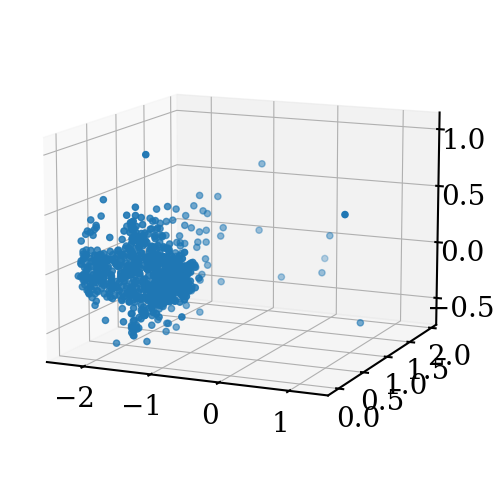

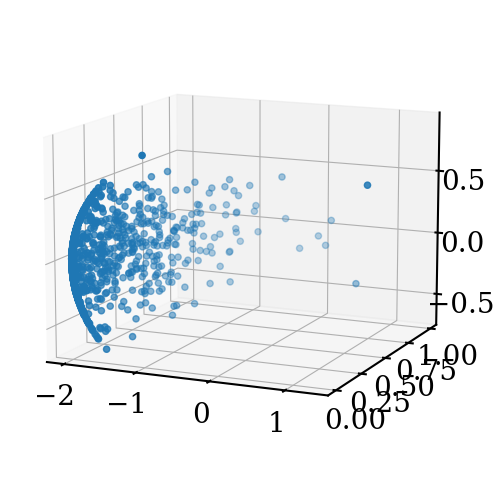

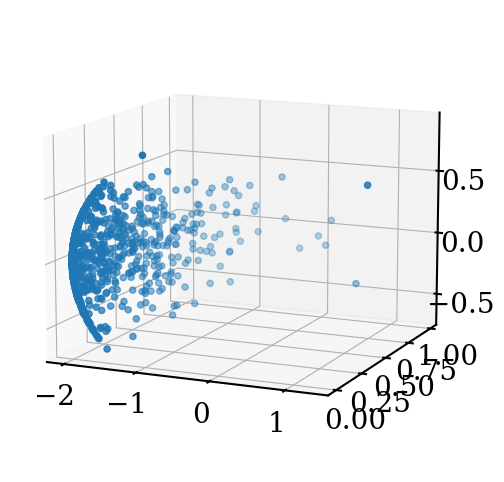

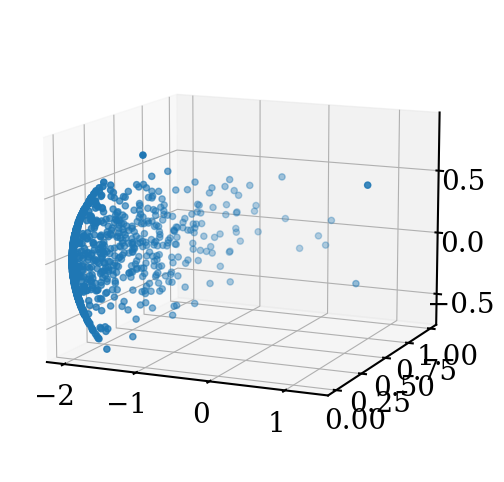

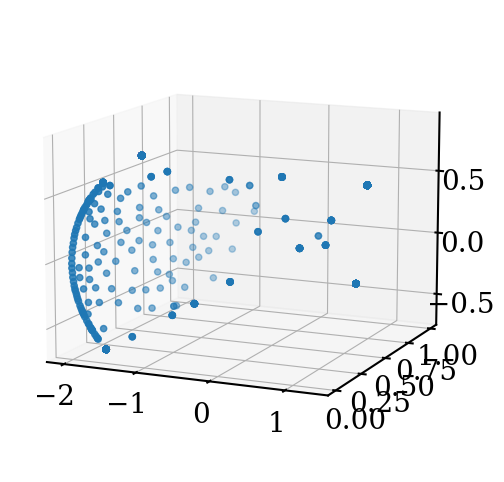

In [9]:
W2_recorder=np.zeros([len(functions),num_experiments,num_iteration//interval+1])
for k in range(len(functions)):
  function=functions[k]
  if function=="ASWD":
    for j in range(num_experiments):
      target_distribution= target.to(device)
      lam=0.05/target_distribution.abs().mean()
      evolving_distribution=source.to(device)
      evolving_distribution=Variable(evolving_distribution,requires_grad=True).to(device)
      optimizer=optim.Adam([evolving_distribution], lr=lr ,betas=(0.9, 0.999))
      phi=Mapping(3).to(device)
      phi_op = optim.Adam(phi.parameters(), lr=0.005, betas=(0.999, 0.999))
      time_sta = time.time()
      for i in range(num_iteration):
        optimizer.zero_grad()
        loss=augmented_sliced_wassersten_distance(evolving_distribution,target_distribution,num_projections,phi,
                                                                phi_op,p=2,max_iter=10,lam=lam,device=device,net_type='fc')
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if (i+1)%interval==0 or i==0:
          M=(((evolving_distribution.unsqueeze(2)-target_distribution.transpose(1,0).unsqueeze(0))**2).sum(1)).cpu().detach().numpy()
          ed1,ed2=np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0],np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0]
          W2=ot.emd2(ed1,ed2,M)**0.5
          if i==0:
            W2_recorder[k,j,i]=W2
          if (i+1)%interval==0:
            W2_recorder[k,j,(i+1)//interval]=W2
          time_end = time.time()
          tim_fast = time_end- time_sta
          print(functions[k],j,tim_fast,W2)
          time_sta = time.time()
      fig = plt.figure(figsize=(8, 6))
      ax = fig.add_subplot(111, projection="3d")
      fig.add_axes(ax)
      ax.scatter(
          evolving_distribution.cpu().detach().numpy()[:,0],evolving_distribution.cpu().detach().numpy()[:,1], evolving_distribution.cpu().detach().numpy()[:,2]
      )
      ax.view_init(azim=-66, elev=12)

  elif function== "DSWD":
    for j in range(num_experiments):
      target_distribution=target.to(device)
      lam=10
      evolving_distribution=source.to(device)
      evolving_distribution=Variable(evolving_distribution,requires_grad=True).to(device)
      optimizer=optim.Adam([evolving_distribution], lr=lr ,betas=(0.9, 0.999))
      transform_net = TransformNet(3).to(device)
      op_trannet = optim.Adam(transform_net.parameters(), lr=0.005, betas=(0.999, 0.999))
      time_sta = time.time()
      for i in range(num_iteration):
        optimizer.zero_grad()
        loss=distributional_sliced_wasserstein_distance(evolving_distribution,target_distribution, num_projections, transform_net,
                                                          op_trannet,p=2, max_iter=10, lam=lam,device=device)
        loss.backward(retain_graph=True)
        optimizer.step()
        if (i+1)%interval==0 or i==0:
          M=(((evolving_distribution.unsqueeze(2)-target_distribution.transpose(1,0).unsqueeze(0))**2).sum(1)).cpu().detach().numpy()
          ed1,ed2=np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0],np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0]
          W2=ot.emd2(ed1,ed2,M)**0.5
          if i==0:
            W2_recorder[k,j,i]=W2
          if (i+1)%interval==0:
            W2_recorder[k,j,(i+1)//interval]=W2
          time_end = time.time()
          tim_fast = time_end- time_sta
          print(functions[k],j,tim_fast,W2)
          time_sta = time.time()
      fig = plt.figure(figsize=(8, 6))
      ax = fig.add_subplot(111, projection="3d")
      fig.add_axes(ax)
      ax.scatter(
          evolving_distribution.cpu().detach().numpy()[:,0],evolving_distribution.cpu().detach().numpy()[:,1], evolving_distribution.cpu().detach().numpy()[:,2]
      )
      ax.view_init(azim=-66, elev=12)

  elif function== wasserstein_distance:
    for j in range(num_experiments):
      target_distribution=target.to(device)
      evolving_distribution=source.to(device)
      evolving_distribution=Variable(evolving_distribution,requires_grad=True).to(device)
      optimizer=optim.Adam([evolving_distribution], lr=lr ,betas=(0.9, 0.999))
      time_sta = time.time()
      for i in range(num_iteration):
        optimizer.zero_grad()
        loss=function(evolving_distribution,target_distribution,device=device)
        loss.backward(retain_graph=True)
        optimizer.step()
        if (i+1)%interval==0 or i==0:
          M=(((evolving_distribution.unsqueeze(2)-target_distribution.transpose(1,0).unsqueeze(0))**2).sum(1)).cpu().detach().numpy()
          ed1,ed2=np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0],np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0]
          W2=ot.emd2(ed1,ed2,M)**0.5
          if i==0:
            W2_recorder[k,j,i]=W2
          if (i+1)%interval==0:
            W2_recorder[k,j,(i+1)//interval]=W2
          time_end = time.time()
          tim_fast = time_end- time_sta
          print(functions[k].__name__,j,tim_fast, W2)
          time_sta = time.time()

      fig = plt.figure(figsize=(8, 6))
      ax = fig.add_subplot(111, projection="3d")
      fig.add_axes(ax)
      ax.scatter(
          evolving_distribution.cpu().detach().numpy()[:,0],evolving_distribution.cpu().detach().numpy()[:,1], evolving_distribution.cpu().detach().numpy()[:,2]
      )
      ax.view_init(azim=-66, elev=12)

  elif function== "SWD":
    for j in range(num_experiments):
      target_distribution=target.to(device)
      evolving_distribution=source.to(device)
      evolving_distribution=Variable(evolving_distribution,requires_grad=True).to(device)
      optimizer=optim.Adam([evolving_distribution], lr=lr ,betas=(0.9, 0.999))
      time_sta = time.time()
      for i in range(num_iteration):
        optimizer.zero_grad()
        loss=sliced_wasserstein_distance(evolving_distribution,target_distribution,num_projections,device=device)
        loss.backward(retain_graph=True)
        optimizer.step()
        if (i+1)%interval==0 or i==0:
          M=(((evolving_distribution.unsqueeze(2)-target_distribution.transpose(1,0).unsqueeze(0))**2).sum(1)).cpu().detach().numpy()
          ed1,ed2=np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0],np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0]
          W2=ot.emd2(ed1,ed2,M)**0.5
          if i==0:
            W2_recorder[k,j,i]=W2
          if (i+1)%interval==0:
            W2_recorder[k,j,(i+1)//interval]=W2
          time_end = time.time()
          tim_fast = time_end- time_sta
          print(functions[k],j,tim_fast, W2)
          time_sta = time.time()

      fig = plt.figure(figsize=(8, 6))
      ax = fig.add_subplot(111, projection="3d")
      fig.add_axes(ax)
      ax.scatter(
          evolving_distribution.cpu().detach().numpy()[:,0],evolving_distribution.cpu().detach().numpy()[:,1], evolving_distribution.cpu().detach().numpy()[:,2]
      )
      ax.view_init(azim=-66, elev=12)


  elif function== "SHWD":
    for j in range(num_experiments):
      target_distribution=target.to(device)
      evolving_distribution=source.to(device)
      evolving_distribution=Variable(evolving_distribution,requires_grad=True).to(device)
      optimizer=optim.Adam([evolving_distribution], lr=lr ,betas=(0.9, 0.999))
      time_sta = time.time()
      for i in range(num_iteration):
        optimizer.zero_grad()
        loss, hoge, hoge2= SHWD(evolving_distribution,target_distribution, train_or_test = "train")
        loss.backward(retain_graph=True)
        optimizer.step()
        if (i+1)%interval==0 or i==0:
          M=(((evolving_distribution.unsqueeze(2)-target_distribution.transpose(1,0).unsqueeze(0))**2).sum(1)).cpu().detach().numpy()
          ed1,ed2=np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0],np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0]
          W2=ot.emd2(ed1,ed2,M)**0.5
          if i==0:
            W2_recorder[k,j,i]=W2
          if (i+1)%interval==0:
            W2_recorder[k,j,(i+1)//interval]=W2
          time_end = time.time()
          tim_fast = time_end- time_sta
          print(functions[k],j,tim_fast, W2)
          time_sta = time.time()
      fig = plt.figure(figsize=(8, 6))
      ax = fig.add_subplot(111, projection="3d")
      fig.add_axes(ax)
      ax.scatter(
          evolving_distribution.cpu().detach().numpy()[:,0],evolving_distribution.cpu().detach().numpy()[:,1], evolving_distribution.cpu().detach().numpy()[:,2]
      )
      ax.view_init(azim=-66, elev=12)


  elif function== "SSWD":
    for j in range(num_experiments):
      target_distribution=target.to(device)
      evolving_distribution=source.to(device)
      evolving_distribution=Variable(evolving_distribution,requires_grad=True).to(device)
      optimizer=optim.Adam([evolving_distribution], lr=lr ,betas=(0.9, 0.999))
      time_sta = time.time()
      for i in range(num_iteration):
        optimizer.zero_grad()
        loss=sliced_wasserstein_sphere(evolving_distribution,target_distribution, num_projections, device=device, p=2)
        loss.backward(retain_graph=True)
        optimizer.step()
        if (i+1)%interval==0 or i==0:
          M=(((evolving_distribution.unsqueeze(2)-target_distribution.transpose(1,0).unsqueeze(0))**2).sum(1)).cpu().detach().numpy()
          ed1,ed2=np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0],np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0]
          W2=ot.emd2(ed1,ed2,M)**0.5
          if i==0:
            W2_recorder[k,j,i]=W2
          if (i+1)%interval==0:
            W2_recorder[k,j,(i+1)//interval]=W2
          time_end = time.time()
          tim_fast = time_end- time_sta
          print(functions[k],j,tim_fast, W2)
          time_sta = time.time()

      fig = plt.figure(figsize=(8, 6))
      ax = fig.add_subplot(111, projection="3d")
      fig.add_axes(ax)
      ax.scatter(
          evolving_distribution.cpu().detach().numpy()[:,0],evolving_distribution.cpu().detach().numpy()[:,1], evolving_distribution.cpu().detach().numpy()[:,2]
      )
      ax.view_init(azim=-66, elev=12)


  elif function== "CD":
    for j in range(num_experiments):
      target_distribution=target.to(device)
      evolving_distribution=source.to(device)
      evolving_distribution=Variable(evolving_distribution,requires_grad=True).to(device)
      optimizer=optim.Adam([evolving_distribution], lr=lr ,betas=(0.9, 0.999))
      time_sta = time.time()
      for i in range(num_iteration):
        optimizer.zero_grad()
        loss = chamfer_distance(evolving_distribution.unsqueeze(0),target_distribution.unsqueeze(0))[0]
        loss.backward(retain_graph=True)
        optimizer.step()
        if (i+1)%interval==0 or i==0:
          M=(((evolving_distribution.unsqueeze(2)-target_distribution.transpose(1,0).unsqueeze(0))**2).sum(1)).cpu().detach().numpy()
          ed1,ed2=np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0],np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0]
          W2=ot.emd2(ed1,ed2,M)**0.5
          if i==0:
            W2_recorder[k,j,i]=W2
          if (i+1)%interval==0:
            W2_recorder[k,j,(i+1)//interval]=W2
          time_end = time.time()
          tim_fast = time_end- time_sta
          print(functions[k],j,tim_fast, W2)
          time_sta = time.time()
      fig = plt.figure(figsize=(8, 6))
      ax = fig.add_subplot(111, projection="3d")
      fig.add_axes(ax)
      ax.scatter(
          evolving_distribution.cpu().detach().numpy()[:,0],evolving_distribution.cpu().detach().numpy()[:,1], evolving_distribution.cpu().detach().numpy()[:,2]
      )
      ax.view_init(azim=-66, elev=12)

  else:
    for j in range(num_experiments):
      target_distribution=target.to(device)
      evolving_distribution=source.to(device)
      evolving_distribution=Variable(evolving_distribution,requires_grad=True).to(device)
      optimizer=optim.Adam([evolving_distribution], lr=lr, betas=(0.9, 0.999))
      time_sta = time.time()
      for i in range(num_iteration):
        optimizer.zero_grad()
        loss=function(evolving_distribution,target_distribution,num_projection=num_projections, device=device)
        loss.backward(retain_graph=True)
        optimizer.step()
        if (i+1)%interval==0 or i==0:
          M=(((evolving_distribution.unsqueeze(2)-target_distribution.transpose(1,0).unsqueeze(0))**2).sum(1)).cpu().detach().numpy()
          ed1,ed2=np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0],np.ones((evolving_distribution.shape[0],))/evolving_distribution.shape[0]
          W2=ot.emd2(ed1,ed2,M)**0.5
          if i==0:
            W2_recorder[k,j,i]=W2
          if (i+1)%interval==0:
            W2_recorder[k,j,(i+1)//interval]=W2
          time_end = time.time()
          tim_fast = time_end- time_sta
          print(functions[k].__name__ ,j,tim_fast, W2)
          time_sta = time.time()

      fig = plt.figure(figsize=(8, 6))
      ax = fig.add_subplot(111, projection="3d")
      fig.add_axes(ax)
      ax.scatter(
          evolving_distribution.cpu().detach().numpy()[:,0],evolving_distribution.cpu().detach().numpy()[:,1], evolving_distribution.cpu().detach().numpy()[:,2]
      )
      ax.view_init(azim=-66, elev=12)

In [15]:
W2_recorder.shape

(5, 1, 201)

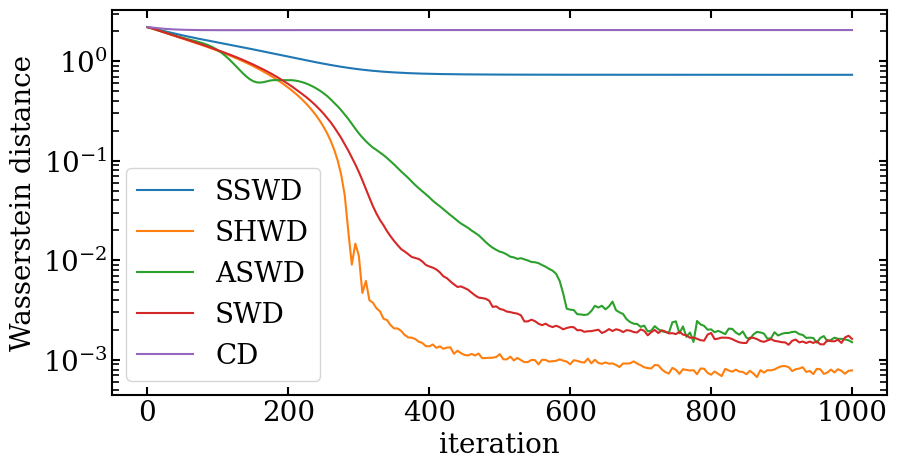

In [14]:
#show
for k in range(len(functions)):
    if type(functions[k]) == str:
        plt.plot(np.arange(num_iteration//interval+1)*interval,W2_recorder[k].mean(0),label=functions[k])
        continue
    plt.plot(np.arange(num_iteration//interval+1)*interval,W2_recorder[k].mean(0),label=functions[k].__name__)
    #ラベル
plt.xlabel('iteration')
plt.ylabel('Wasserstein distance')
plt.yscale('log')
plt.legend()
plt.show()